# ELEC 478 Final Code Submission
Grace Wang and Didi Zhou

## Load in Packages

In [8]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import balanced_accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection
from sklearn.svm import SVC
# from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# from sklearn.ensemble import BaggingClassifier
from xgboost import plot_tree
import random
from sklearn.impute import KNNImputer
import math
import time



## Preprocessing

### Data Imputation for Morph Embeddings
Use kNN Imputation to fill in missing pre- morph embeddings. (Takes a while to run, but we have provided the results file which can be loaded in)

In [ ]:
#load in training data on each ADP / potential synapse
data = pd.read_csv("Data/train_data.csv")

#load in morph embedding df
morph_embeddings = pd.read_csv("Data/morph_embeddings.csv")

# merge ADP data with morph embedding data
full_data = (
    data.merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

# get only the morph embeddings back out (some pre-morph embeddings
# will be null)
morph_embed = full_data.filter(regex="_morph_emb_")

# complete the imputation
imputer = KNNImputer(n_neighbors=2)
imputed_morph_embed = imputer.fit_transform(morph_embed)
imputed_morph_embed_df = pd.DataFrame(imputed_morph_embed)
csv_imputed_morph_embed_df = imputed_morph_embed_df.copy()

# save to CSV
csv_imputed_morph_embed_df.to_csv('Data/imputed_morph_embed.csv',index=False)


In [ ]:
# the resulting dataframe
pd.read_csv('Data/imputed_morph_embed.csv').head(5)

,pre_morph_emb_0,pre_morph_emb_1,pre_morph_emb_2,pre_morph_emb_3,pre_morph_emb_4,pre_morph_emb_5,pre_morph_emb_6,pre_morph_emb_7,pre_morph_emb_8,pre_morph_emb_9,...,post_morph_emb_22,post_morph_emb_23,post_morph_emb_24,post_morph_emb_25,post_morph_emb_26,post_morph_emb_27,post_morph_emb_28,post_morph_emb_29,post_morph_emb_30,post_morph_emb_31
0,0.373316,0.209818,-0.546946,0.630883,0.832248,-0.983688,1.085743,-0.395466,-1.151271,-0.495176,...,-1.064851,-0.816273,-0.215224,-0.598382,0.545335,-0.525224,0.171648,1.022962,-0.645146,-0.687774
1,0.373316,0.209818,-0.546946,0.630883,0.832248,-0.983688,1.085743,-0.395466,-1.151271,-0.495176,...,-1.064851,-0.816273,-0.215224,-0.598382,0.545335,-0.525224,0.171648,1.022962,-0.645146,-0.687774
2,0.373316,0.209818,-0.546946,0.630883,0.832248,-0.983688,1.085743,-0.395466,-1.151271,-0.495176,...,-1.064851,-0.816273,-0.215224,-0.598382,0.545335,-0.525224,0.171648,1.022962,-0.645146,-0.687774
3,0.373316,0.209818,-0.546946,0.630883,0.832248,-0.983688,1.085743,-0.395466,-1.151271,-0.495176,...,-1.064851,-0.816273,-0.215224,-0.598382,0.545335,-0.525224,0.171648,1.022962,-0.645146,-0.687774
4,0.373316,0.209818,-0.546946,0.630883,0.832248,-0.983688,1.085743,-0.395466,-1.151271,-0.495176,...,-1.064851,-0.816273,-0.215224,-0.598382,0.545335,-0.525224,0.171648,1.022962,-0.645146,-0.687774


## Data Cleaning & Feature Engineering

In [10]:
def cleaner(train, feature, imp_morph):
    """
    Function that performs data cleaning and feature engineering for the data

    inputs:
    - train: path to training data
    - feature: path to feature data
    - imp_morph: path to imputed morph embedding data

    outputs:
    - data: cleaned and feature engineered data
    """

    data = pd.read_csv(train)

    ############## CONCAT FEATURE WEIGHT DATA ##############
    
    #load in feature weight information for each neuron
    feature_weights = pd.read_csv(feature)
        
    # make feature_weights into a numPy array
    feature_weights["feature_weights"] = (feature_weights.filter(regex="feature_weight_").sort_index(axis=1)
                                        .apply(lambda x: np.array(x), axis=1))

    # delete the feature_weight_i columns
    feature_weights.drop(
        feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True)
    
    # update data with feature weight information for pre- and post- neurons
    data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    ))
    
    ############## CONCAT IMPUTED MORPH EMBEDDINGS ################
    # load in imputed morph embedding data
    morph_embs = pd.read_csv(imp_morph)

    # put all the morph embedding data into vectors
    morph_embs["pre_morph_embeddings"] = (morph_embs.filter(regex="pre_morph_emb_").sort_index(axis=1)
                                          .apply(lambda x: np.array(x), axis=1))
    
    morph_embs["post_morph_embeddings"] = (morph_embs.filter(regex="post_morph_emb_")
                                           .sort_index(axis=1).apply(lambda x: np.array(x), axis=1))
    
    # drop the individual morph embedding columns
    morph_embs.drop(morph_embs.filter(regex="_morph_emb_").columns, axis=1, inplace=True)
    morph_embs["ID"] = data["ID"]

    # merge the main df with morph embeddings
    data = data.merge(morph_embs, on="ID")

    ############## Preprocessing: ONE HOT ENCODE BRAIN AREA ##############
    data = one_hot('pre_brain_area', data, '_pre')
    data = one_hot('post_brain_area', data, '_post')


    ############## Preprocessing: BRAIN COMPARTMENT GROUPING ##############
    data = area_cols(data)

    ############## FE: CALCULATE SIMILARITY BETWEEN PRE- AND POST- MORPH EMBEDDINGS ###################
    data["me_similarity"] = data.apply(row_morph_similarity, axis=1)
    
    ############## FE: CALCULATE SIMILARITY BETWEEN PRE- AND POST- FEATURE WEIGHTS ##############
    data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
    
    ############## FE: COMBINE COORDINATES INTO ARRAYS ##############
    data = coord_column(data, "axonal_coords", "axonal_coor_")
    data = coord_column(data, "dendritic_coords", "dendritic_coor_")
    data = coord_column(data, "pre_rf_coords", "pre_rf_[xy]")
    data = coord_column(data, "post_rf_coords", "post_rf_[xy]")
    data = coord_column(data, "pre_nucleus_coords", "pre_nucleus_[xyz]")
    data = coord_column(data, "post_nucleus_coords", "post_nucleus_[xyz]")
    data = coord_column(data, "pre_nucleus_xy", "pre_nucleus_[xy]")
    data = coord_column(data, "post_nucleus_xy", "post_nucleus_[xy]")

    ############## FE: RF Distance ##############
    data = coord_rf(data)
    data["rf_distance"] = data.apply(rfdistance, axis=1)


    ############## FE: MINICOLUMNS ##############
    data["minicol_dist"] =  data[["pre_nucleus_xy", "post_nucleus_xy"]].apply(
    lambda x: math.dist(x["pre_nucleus_xy"], x["post_nucleus_xy"]), axis=1)

    ############## FE: DISTANCE FROM PRE-SYNAPTIC NUCLEUS TO AXON ##############
    data["nuclei_adp_dist"] =  data[["pre_nucleus_coords", "axonal_coords"]].apply(
    lambda x: math.dist(x["pre_nucleus_coords"], x["axonal_coords"]), axis=1)

    ############## STANDARDIZE ALL NUMERIC DATA #############
    num_cols = data.select_dtypes(include='number').drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id'])
    num_cols = num_cols.columns
    for column in num_cols:
        data[column] = StandardScaler().fit_transform(np.array(data[column]).reshape(-1, 1))
    
    # return processed data
    return data

def row_feature_similarity(row):
    """
    Cosine similarity function for feature weight similarity

    Inputs: row - a row of the dataframe containing feature weight information
    Outputs: the cosine similarity between the pre and post feature weights
    """
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

def row_morph_similarity(row):
    """
    Morph embedding similarity function for feature weight similarity

    Inputs: row - a row of the dataframe containing feature weight information
    Outputs: the cosine similarity between the pre and post morph embeddings
    """
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))


def coord_column(df, new_col, old_cols):
    """
    Function that combines coordinate data into an array of coordinates
    Inputs:
        - df: the data frame
        - new_col: the new column created to store the coordinate array
        - old_cols: the old coordinate columns to be combined to form the new column
    Outputs:
        - df: the updated data frame
    """
    df[new_col] = (
        df.filter(regex=old_cols)
        .sort_index(axis=1)
        .apply(lambda x: np.array(x), axis=1)
    )
    
    return df

def coord_rf(df):
    """
    Function that combines coordinate data for the rf data 
    (readout location of deep learning model)
    Inputs:
        - df: the data frame
    Outputs:
        - df: the updated data frame
    """
    df = coord_column(df, "pre_rf_coords_xy", "pre_rf_[xy]")
    df = coord_column(df, "post_rf_coords_xy", "post_rf_[xy]")
    return df

def rfdistance(row):
    """
    Function that calculates the distance between the rf locations
    Inputs:
        - row: a row describing one ADP
    Outputs:
        - the distance between the pre- and post- neuron readout locations
    """
    pre = row["pre_rf_coords_xy"]
    post = row["post_rf_coords_xy"]
    return math.dist(pre, post)

def one_hot(column, df, suffix=''):
    """
    Function for one-hot encoding

    Inputs:
        - column: the column to be one-hot encoded
        - df: the dataframe
        - suffix: an optional suffix to be added to the column when it is one-hot encoded
    
    Outputs:
        - df: the updated dataframe
    """
    cats = pd.unique(df[column])

    for cat in cats:
        new_col = cat+suffix
        df[new_col] = df[column]==cat
        df[new_col] = df[new_col].astype('int')
    
    df = df.drop(columns=column)
    return df

def area_cols(df):
    """
    Function that groups and encodes the compartment data
    Inputs:
        - df: the data frame
    Outputs:
        - df: the updated data frame with grouped compartments
    """
    # Encode brain areas
    area1 = ["basal", "soma"] # the cell body
    area2 = ["axon", "apical", "oblique", "apical_shaft"] # axonal areas
    area3 = ["apical_tuft"] # terminal areas
    df["area1"] = df["compartment"].isin(area1).astype('int')
    df["area2"] = df["compartment"].isin(area2).astype('int')
    df["area3"] = df["compartment"].isin(area3).astype('int')
    return df


In [11]:
# Run the cleaning
train_path = "Data/train_data.csv"
feature_path = "Data/feature_weights.csv"
morph_path = "Data/imputed_morph_embed.csv"
clean_data = cleaner(train_path, feature_path, morph_path)

## Data Splitting

In [12]:
def splitter(data):
    """
    Data splitting function

    Inputs:
        - data: the data to be split
    
    Outputs:
        - X_train, y_train: the training data
        - X_query, y_query: the query data
    """
    # perform stratified sampling on pre-synaptic neurons
    pre_nucleus_ids = pd.unique(data["pre_nucleus_id"])

    # Use 80% of the pre-nucleus ids
    train_nucleus_idx = random.sample(range(0, len(pre_nucleus_ids)), int(np.floor(0.8*len(pre_nucleus_ids))))
    train_nucleus_ids = pre_nucleus_ids[train_nucleus_idx]
    training = data[data["pre_nucleus_id"].isin(train_nucleus_ids)]
    X_train = training.drop(columns='connected')
    y_train = training['connected']
    pre_nucleus_ids = np.delete(pre_nucleus_ids, train_nucleus_idx)

    # Use 20% for query
    query = data[data["pre_nucleus_id"].isin(pre_nucleus_ids)]
    X_query = query.drop(columns='connected')
    y_query = query['connected']

    return X_train, X_query, y_train, y_query

In [13]:
random.seed(1)
X_train, X_query, y_train, y_query = splitter(clean_data)

In [14]:
# create a copy of X_train with y_train to use for cross-validation
X_cv = X_train.copy()
X_cv['connected']=y_train

## XGBoost

### Hyperparameter Tuning
Tune maximum tree depth, learning rate, and L2 regularization strength.
For our submission to the leaderboard, we tested tree depths in [3, 14], learning rates from [0.1, 1.0] with a step size of 0.1 and lambda values of [0, 2.0] with a step size of 0.1. Observing our results from this, we decided to keep the ranges for learning rates and lambda values the same, but change the range for maximum tree depth to [1, 10].

In [ ]:
## parameters for leaderboard submissions
# max_depths = range(3, 15)
# eta_val = np.arange(0.1, 1.1, 0.1)
# lambda_val = np.arange(0, 2.1, 0.1)

# parameters for revised submissions
max_depths = range(1, 11)
eta_val = np.arange(0.1, 1.1, 0.1)
lambda_val = np.arange(0, 2.1, 0.1)

accuracies = {}
stdevs = {}
times = {}
for depth in max_depths:
    for lam in lambda_val:
        for etav in eta_val:
            fold_accuracy = []
            avg_train_time = 0
            for fold in [1,2,3,4,5]:      
                # subset of data
                random.seed(fold) # set seed for reproducibility across models
                X_train_fold, X_val_fold, y_train_fold, y_val_fold = splitter(X_cv)
                ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
                X_train_fold, y_train_fold = ros.fit_resample(
                    X_train_fold, y_train_fold)  # oversample minority class
                
                X_train_fold = X_train_fold.select_dtypes('number') # select numeric columns
                X_val_fold = X_val_fold.select_dtypes('number')     # select numeric columns
                
                XGB = XGBClassifier(max_depth=depth, reg_lambda=lam, learning_rate=etav) # fit XGBoost

                startt = time.time()
                XGB.fit(X_train_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"])
                        ,y_train_fold) # fit model
                endt = time.time(); elapsed = endt-startt # training time
                
                y_hat_valid = XGB.predict(
                    X_val_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"])) # predict
                
                valid_acc = balanced_accuracy_score(y_val_fold, y_hat_valid) # validation accuracy
                fold_accuracy.append(valid_acc)
                avg_train_time += elapsed
                print(f"tree depth: {depth}, lambda: {lam}, learning rate: {etav} valid accuracy for this fold, {valid_acc}")
            avg_fold_accuracy = sum(fold_accuracy)/len(fold_accuracy) # calculate average accuracy
            fold_std = np.std(fold_accuracy) # calculate standard deviation
            print(f"avgfold accuracy: {avg_fold_accuracy}")
            print(f"standard deviation: {fold_std}")
            print(f"avg train time: {avg_train_time/5}")
            accuracies[(depth, lam, etav)] = avg_fold_accuracy # store values
            stdevs[(depth, lam, etav)] = fold_std
            times[(depth, lam, etav)] = avg_train_time/5
    

tree depth: 1, lambda: 0.0, learning rate: 0.1 valid accuracy for this fold, 0.7539871486570737
tree depth: 1, lambda: 0.0, learning rate: 0.1 valid accuracy for this fold, 0.7617660493726857
tree depth: 1, lambda: 0.0, learning rate: 0.1 valid accuracy for this fold, 0.7506885690475854
tree depth: 1, lambda: 0.0, learning rate: 0.1 valid accuracy for this fold, 0.7561199826566666
tree depth: 1, lambda: 0.0, learning rate: 0.1 valid accuracy for this fold, 0.7554423230400884
avgfold accuracy: 0.75560081455482
standard deviation: 0.0036066285916499814
avg train time: 0.5254045009613038
tree depth: 1, lambda: 0.0, learning rate: 0.2 valid accuracy for this fold, 0.7688512048259084
tree depth: 1, lambda: 0.0, learning rate: 0.2 valid accuracy for this fold, 0.7671102733678903
tree depth: 1, lambda: 0.0, learning rate: 0.2 valid accuracy for this fold, 0.7670143907661386
tree depth: 1, lambda: 0.0, learning rate: 0.2 valid accuracy for this fold, 0.7693484257234846
tree depth: 1, lambda: 0

In [ ]:
acc_df = pd.DataFrame({'Param Pair':accuracies.keys(), 'Avg Accuracy':accuracies.values()})
std_df = pd.DataFrame({'Param Pair':stdevs.keys(), 'Standard Dev':stdevs.values()})
time_df = pd.DataFrame({'Param Pair':times.keys(), 'Training Time':times.values()})
xg_hyperparams = acc_df.merge(std_df, on='Param Pair').merge(time_df, on='Param Pair')

In [ ]:
# show the 5 best parameters
xg_hyperparams = xg_hyperparams.sort_values(by='Avg Accuracy', ascending=False).reset_index()
xg_hyperparams.head(5)
xg_hyperparams.to_csv('final_xg_hyperparams.csv')
# hyperparameters for submitted models were saved to xgb_accuracy_est_leaf_eta_cv.csv

In [ ]:
# best parameters
xg_best_param = xg_hyperparams['Param Pair'][0]
xg_best_param

(3, 0.6000000000000001, 0.1)

In [ ]:
# get Standard Deviation
xg_hyperparams["Standard Dev"][0]

0.0045757650884054755

In [ ]:
def get_param0(row):
    """ 
    Helper function to create a column in the hyperparams dataframe 
    for the first hyperparameter

    Inputs: 
        - row: a row of the hyperparameter dataframe
    """
    param_pair = row["Param Pair"]
    return param_pair[0]

def get_param1(row):
    """ 
    Helper function to create a column in the hyperparams dataframe 
    for the second hyperparameter

    Inputs: 
        - row: a row of the hyperparameter dataframe
    """
    param_pair = row["Param Pair"]
    return param_pair[1]

def get_param2(row):
    """ 
    Helper function to create a column in the hyperparams dataframe 
    for the third hyperparameter

    Inputs: 
        - row: a row of the hyperparameter dataframe
    """
    param_pair = row["Param Pair"]
    return param_pair[2]

In [ ]:
hyp_idx = 0; xg_hyperparams["Tree Depth"] = xg_hyperparams.apply(get_param0, axis=1)
hyp_idx = 1; xg_hyperparams["Lambda"] = xg_hyperparams.apply(get_param1, axis=1)
hyp_idx = 2; xg_hyperparams["Learning Rate"] = xg_hyperparams.apply(get_param2, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

Text(0.5, 1.0, 'XGBoost: Tuning Learning Rate')

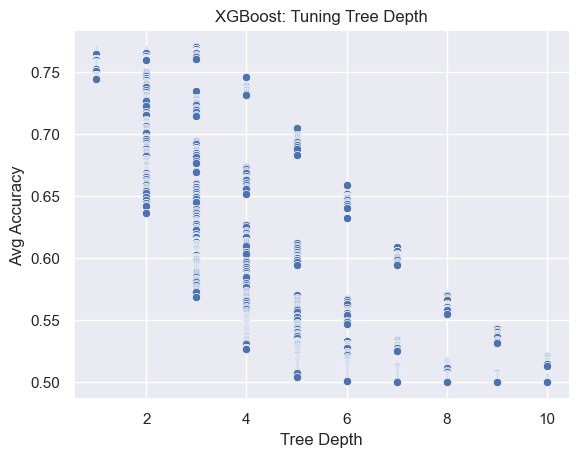

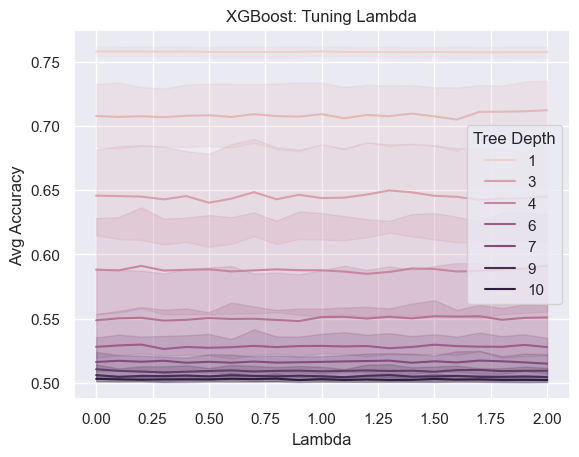

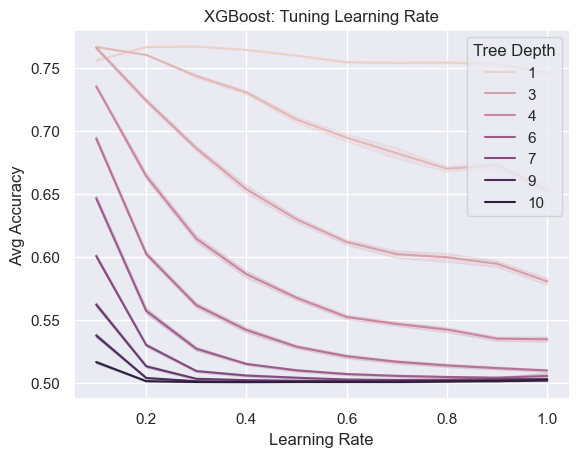

In [ ]:
# create plots to visualize hyperparameter tuning
plt.figure()
sns.scatterplot(xg_hyperparams, x='Tree Depth', y='Avg Accuracy')
plt.title('XGBoost: Tuning Tree Depth')

plt.figure()
sns.lineplot(xg_hyperparams, x='Lambda', y='Avg Accuracy', hue="Tree Depth")
plt.title('XGBoost: Tuning Lambda')

plt.figure()
sns.lineplot(xg_hyperparams, x='Learning Rate', y='Avg Accuracy', hue='Tree Depth')
plt.title('XGBoost: Tuning Learning Rate')

### Score on Query Set

In [ ]:
# prepare data
X_train=X_train.select_dtypes('number')
ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
X_train_use, y_train_use = ros.fit_resample(
                    X_train, y_train) 
X_query = X_query.select_dtypes('number')

In [ ]:
xg_model = XGBClassifier(max_depth=xg_best_param[0], reg_lambda=xg_best_param[1], learning_rate=xg_best_param[2]) # fit model
xg_model.fit(X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1), y_train_use)

# make predictions on query set
xg_preds = xg_model.predict(X_query.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
xg_accuracy = balanced_accuracy_score(y_query, xg_preds)
print(f"XGBoost Balanced Accuracy on Query Set: {xg_accuracy}")

XGBoost Balanced Accuracy on Query Set: 0.7515812554256209


### Model Analysis

In [ ]:
# extract feature importances
xg_features = pd.DataFrame({"Features":X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).columns, 
              "Importances":abs(xg_model.feature_importances_)}).sort_values(by='Importances', ascending=False)
xg_features

,Features,Importances
6,adp_dist,0.205895
14,post_test_score,0.051042
26,RL_pre,0.047841
7,post_skeletal_distance_to_soma,0.045103
8,pre_skeletal_distance_to_soma,0.044928
18,pre_nucleus_y,0.037207
19,pre_nucleus_z,0.033861
29,RL_post,0.032576
11,pre_rf_x,0.031916
32,area1,0.031404


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'XGBoost Feature Importance')

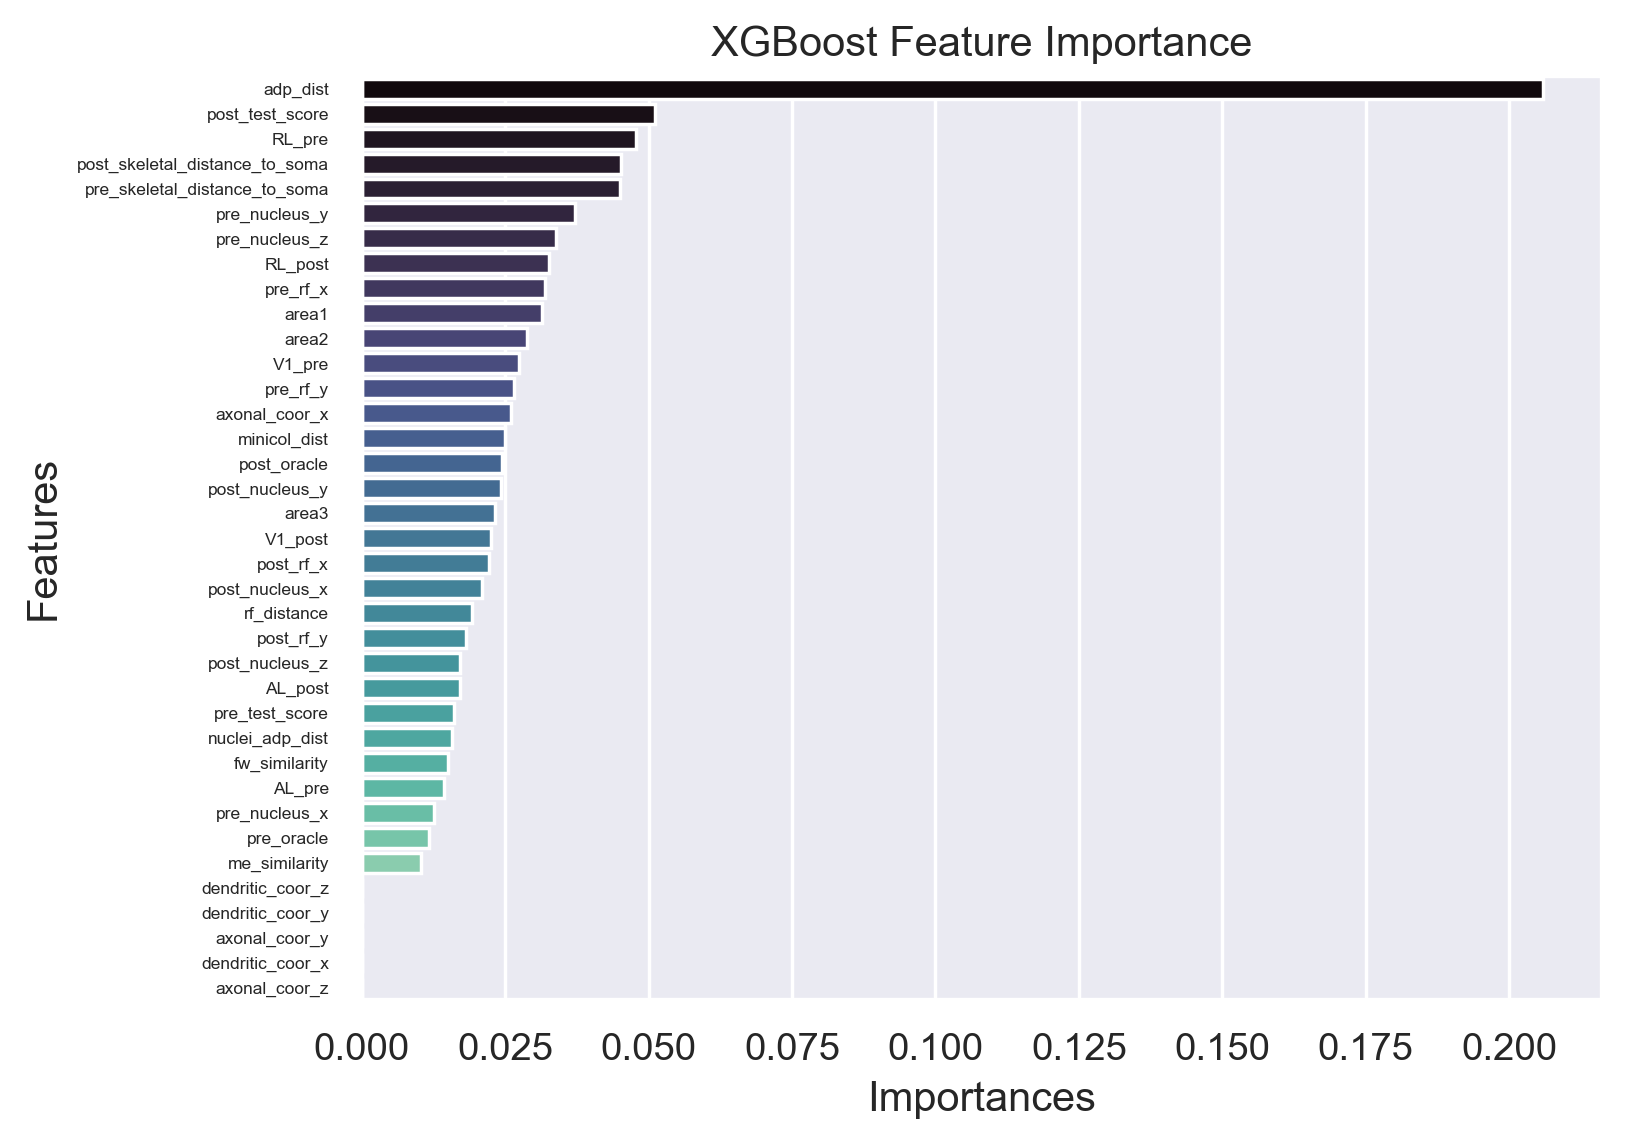

In [ ]:
# create plot of feature importances
sns.set_theme(palette='deep')
plt.figure(dpi=250)
g = sns.barplot(xg_features, y='Features', x='Importances', palette='mako')
g.set_yticklabels(g.get_yticklabels(), fontsize=5)
plt.title("XGBoost Feature Importance")

### Make a Submission

In [ ]:
leaderboard_path = "Data/leaderboard_data.csv"
sub_data = cleaner(leaderboard_path, feature_path, morph_path)
sub_data = sub_data.select_dtypes('number')
preds = xg_model.predict(sub_data.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
sub_data['connected_pred'] = preds==1
submission_data = sub_data.filter(['ID','connected_pred'])
submission_data.to_csv('final_submission_data_xg.csv',index=False)

In [ ]:
# evaluate against real leaderbaord data
solutions = pd.read_csv('Data/solution_data.csv')
leaderboard = pd.concat([solutions,submission_data], axis=1)
public = leaderboard[leaderboard["Usage"]=="Public"]
print("Public Accuracy Score:", balanced_accuracy_score(public["connected"], public["connected_pred"]))
private = leaderboard[leaderboard["Usage"]=="Private"]
print("Private Accuracy Score:", balanced_accuracy_score(private["connected"], private["connected_pred"]))


Public Accuracy Score: 0.7550977356024662
Private Accuracy Score: 0.7513936646868813


## Random Forest

### Hyperparameter Tuning
Tune maximum tree depth and number of features.
For our submission to the leaderboard and for this report, we tested tree depths in [1, 10] and number of features in [1, 20]. For this report, we decided to test number of features in [1, 20] with a step size of 2. We also decided to test a varying number of estimators. We tested $10^2$ and $10^3$ trees.

In [ ]:
## hyperparameters for submission
# max_depth_list = np.linspace(1,10, num = 10, dtype=int)
# num_features = np.linspace(1,20, num = 20, dtype = int)

# revised hyperparameters
max_depth_list = np.linspace(1,10, num = 10, dtype=int)
num_features = np.linspace(1,20, num = 10, dtype = int)
n_ests = [10**2, 10**3]

accuracies = {}
stdevs = {}
times = {}
for depth in max_depth_list:
    for num in num_features:
        for ests in n_ests:
            fold_accuracy = []
            avg_train_time = 0
            for fold in [1,2,3,4,5]:      
                # subset of the data
                random.seed(fold)
                X_train_fold, X_val_fold, y_train_fold, y_val_fold = splitter(X_cv)
                ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
                X_train_fold, y_train_fold = ros.fit_resample(
                    X_train_fold, y_train_fold) # oversample minority class
                
                X_train_fold = X_train_fold.select_dtypes('number')
                X_val_fold = X_val_fold.select_dtypes('number')    
                    
                RF = RandomForestClassifier(n_estimators = ests, max_depth=depth, max_features = num) 
                
                startt = time.time()
                RF.fit(X_train_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]),y_train_fold)
                endt = time.time(); elapsed = endt-startt

                y_hat_valid = RF.predict(X_val_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]))
                
                valid_acc = balanced_accuracy_score(y_val_fold, y_hat_valid)
                fold_accuracy.append(valid_acc)
                avg_train_time += elapsed
                print(f"num estimators: {ests}, depth: {depth}, num features {num}, valid accuracy for this fold, {valid_acc}")
            avg_fold_accuracy = sum(fold_accuracy)/len(fold_accuracy)
            fold_std = np.std(fold_accuracy)
            print(f"avgfold accuracy: {avg_fold_accuracy}")
            print(f"standard deviation: {fold_std}")
            print(f"avg train time: {avg_train_time/5}")
            accuracies[(ests, depth, num)] = avg_fold_accuracy
            stdevs[(ests, depth, num)] = fold_std
            times[(ests, depth, num)] = avg_train_time/5
    
    

num estimators: 100, depth: 1, num features 1, valid accuracy for this fold, 0.7330495520243216
num estimators: 100, depth: 1, num features 1, valid accuracy for this fold, 0.6160765451758449
num estimators: 100, depth: 1, num features 1, valid accuracy for this fold, 0.7288354930729823
num estimators: 100, depth: 1, num features 1, valid accuracy for this fold, 0.6255316008450262
num estimators: 100, depth: 1, num features 1, valid accuracy for this fold, 0.6125559698906248
avgfold accuracy: 0.6632098322017599
standard deviation: 0.055482111460817524
avg train time: 1.9123390674591065
num estimators: 1000, depth: 1, num features 1, valid accuracy for this fold, 0.7017855731116522
num estimators: 1000, depth: 1, num features 1, valid accuracy for this fold, 0.6846692990580805
num estimators: 1000, depth: 1, num features 1, valid accuracy for this fold, 0.6853923444200143
num estimators: 1000, depth: 1, num features 1, valid accuracy for this fold, 0.728269172224836
num estimators: 1000

In [ ]:
acc_df = pd.DataFrame({'Param Pair':accuracies.keys(), 'Avg Accuracy':accuracies.values()})
std_df = pd.DataFrame({'Param Pair':stdevs.keys(), 'Standard Dev':stdevs.values()})
time_df = pd.DataFrame({'Param Pair':times.keys(), 'Training Time':times.values()})
rf_hyperparams = acc_df.merge(std_df, on='Param Pair').merge(time_df, on='Param Pair')

In [ ]:
# show the 5 best parameters
rf_hyperparams = rf_hyperparams.sort_values(by='Avg Accuracy', ascending=False).reset_index()
rf_hyperparams.head(5)
rf_hyperparams.to_csv('final_rf_hyperparams.csv')
# hyperparameters for submitted models were saved to rf_depth_feat_cv.csv

In [ ]:
# best parameters
rf_best_param = rf_hyperparams['Param Pair'][0]
rf_best_param

(100, 6, 7)

In [ ]:
# get Standard Deviation
rf_hyperparams["Standard Dev"][0]

,index,Param Pair,Avg Accuracy,Standard Dev,Training Time,Num Estimators,Tree Depth,Num Features
0,106,"(100, 6, 7)",0.773917,0.008084,0.008084,100,6,7


In [ ]:
rf_hyperparams["Num Estimators"] = rf_hyperparams.apply(get_param0, axis=1)
rf_hyperparams["Tree Depth"] = rf_hyperparams.apply(get_param1, axis=1)
rf_hyperparams["Num Features"] = rf_hyperparams.apply(get_param2, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

Text(0.5, 1.0, 'Random Forest: Tuning Number of Features')

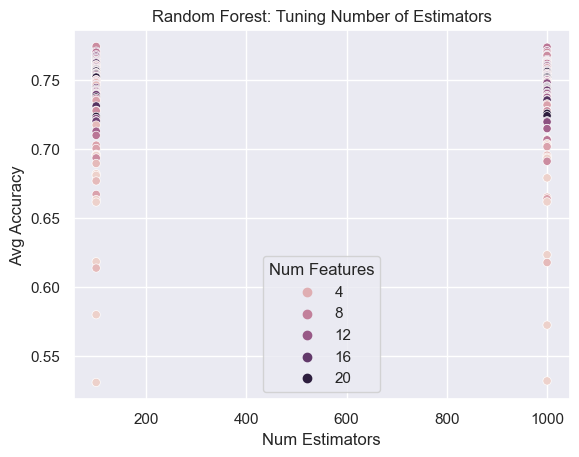

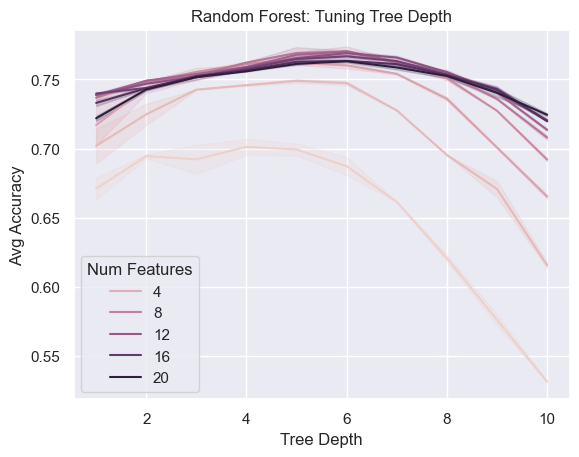

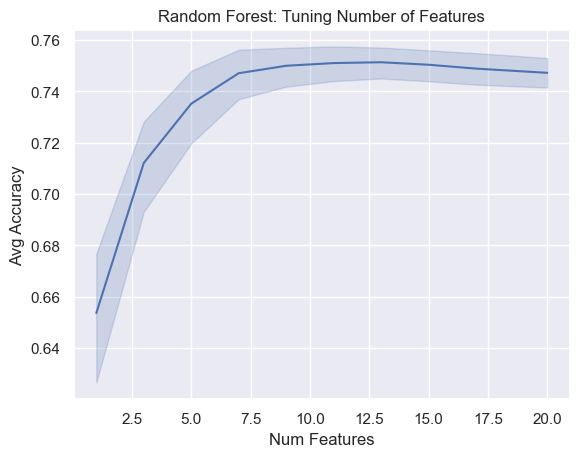

In [ ]:
# create plots to visualize hyperparameter tuning
plt.figure()
sns.scatterplot(rf_hyperparams, x='Num Estimators', y='Avg Accuracy', hue="Num Features")
plt.title('Random Forest: Tuning Number of Estimators')

plt.figure()
sns.lineplot(rf_hyperparams, x='Tree Depth', y='Avg Accuracy', hue='Num Features')
plt.title('Random Forest: Tuning Tree Depth')

plt.figure()
sns.lineplot(rf_hyperparams, x='Num Features', y='Avg Accuracy')
plt.title('Random Forest: Tuning Number of Features')

### Score on Query Set

In [ ]:
rf_model = RandomForestClassifier(n_estimators=rf_best_param[0], max_depth=rf_best_param[1], max_features=rf_best_param[2])
rf_model.fit(X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1), y_train_use)

preds = rf_model.predict(X_query.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
rf_accuracy = balanced_accuracy_score(y_query, preds)
print(f"Random Forest Balanced Accuracy on Query Set: {rf_accuracy}")

Random Forest Balanced Accuracy on Query Set: 0.7525127017780182


### Model Analysis

In [ ]:
# extract feature importances
rf_features = pd.DataFrame({"Features":X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).columns, 
              "Importances":abs(rf_model.feature_importances_)}).sort_values(by='Importances', ascending=False)
rf_features

,Features,Importances
6,adp_dist,0.507509
26,RL_pre,0.079940
19,pre_nucleus_z,0.037698
11,pre_rf_x,0.035877
14,post_test_score,0.034787
21,post_nucleus_y,0.033918
8,pre_skeletal_distance_to_soma,0.030270
18,pre_nucleus_y,0.026625
28,V1_pre,0.017294
13,post_oracle,0.016790


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Random Forest Feature Importance')

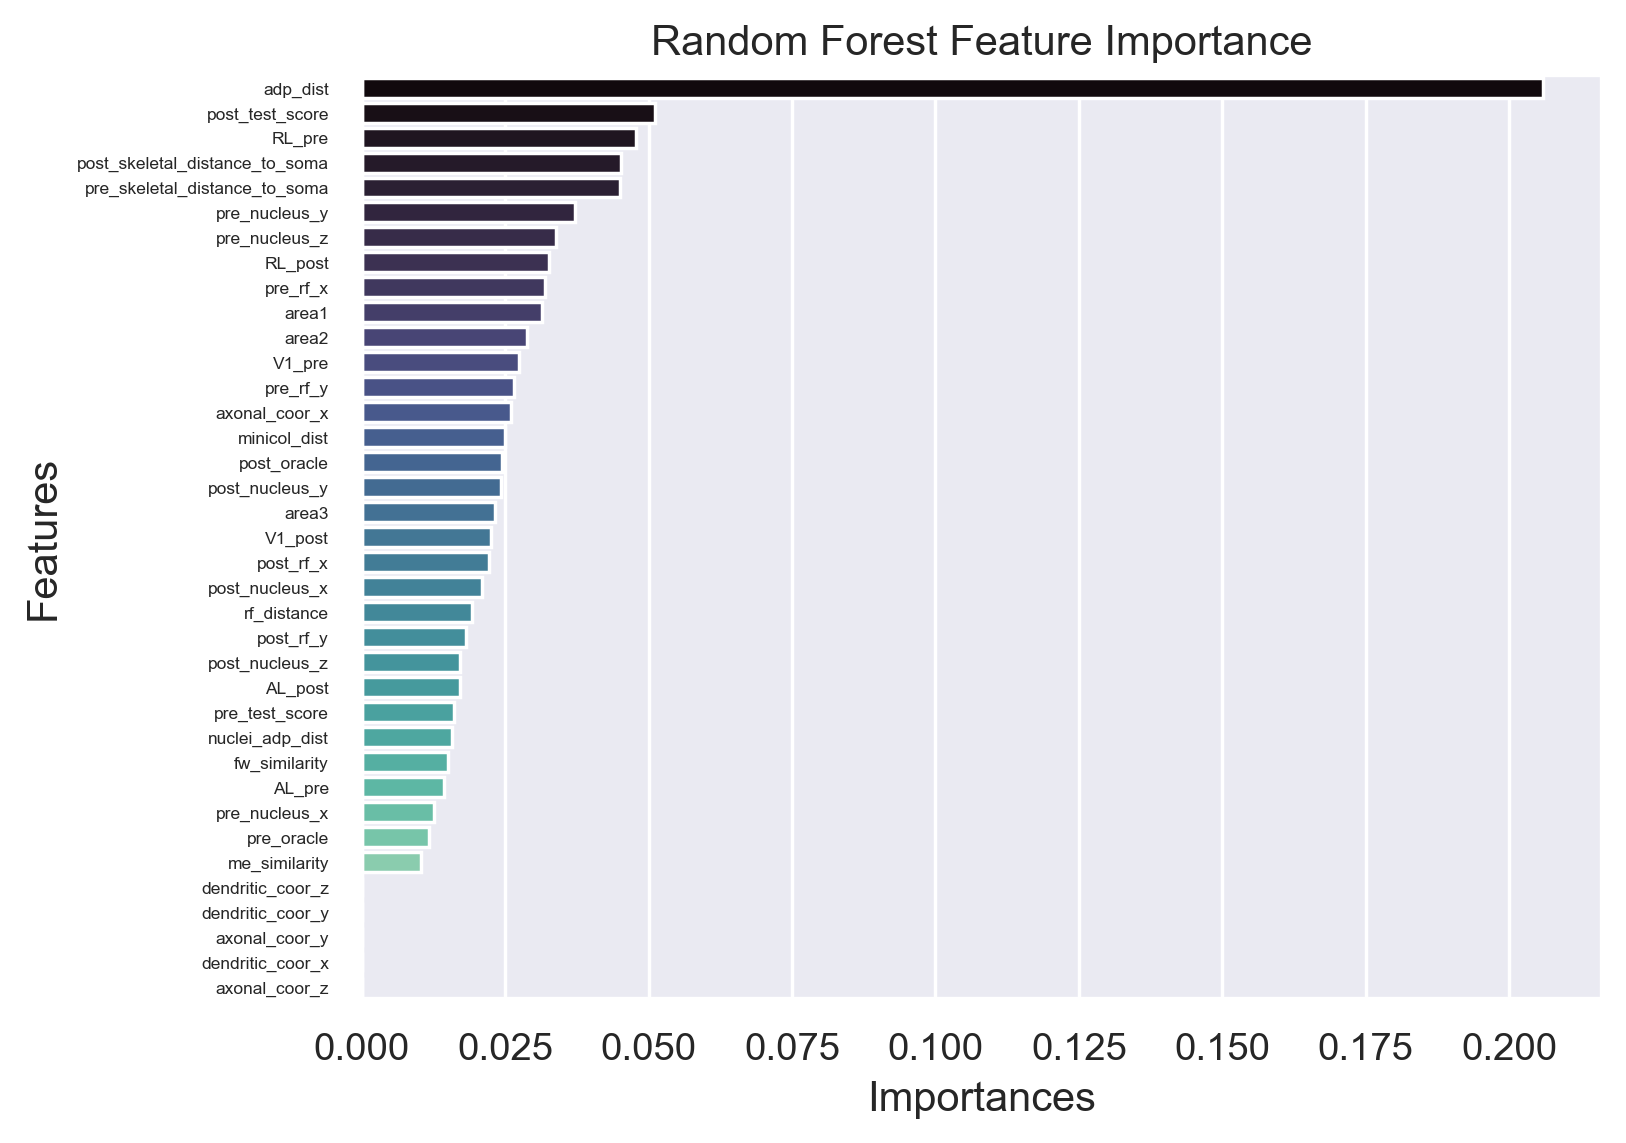

In [ ]:
# create plot of feature importances
sns.set_theme(palette='deep')
plt.figure(dpi=250)
g = sns.barplot(xg_features, y='Features', x='Importances', palette='mako')
g.set_yticklabels(g.get_yticklabels(), fontsize=5)
plt.title("Random Forest Feature Importance")

### Make a Submission

In [ ]:
leaderboard_path = "Data/leaderboard_data.csv"
sub_data = cleaner(leaderboard_path, feature_path, morph_path)
sub_data = sub_data.select_dtypes('number')
preds = rf_model.predict(sub_data.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
sub_data['connected_pred'] = preds==1
submission_data = sub_data.filter(['ID','connected_pred'])
submission_data.to_csv('final_submission_data_rf.csv',index=False)

# evaluate against real leaderbaord data
solutions = pd.read_csv('Data/solution_data.csv')
leaderboard = pd.concat([solutions,submission_data], axis=1)
public = leaderboard[leaderboard["Usage"]=="Public"]
print("Public Accuracy Score:", balanced_accuracy_score(public["connected"], public["connected_pred"]))
private = leaderboard[leaderboard["Usage"]=="Private"]
print("Private Accuracy Score:", balanced_accuracy_score(private["connected"], private["connected_pred"]))


Public Accuracy Score: 0.7539140409694007
Private Accuracy Score: 0.7519353474431347


## Logistic Regression

## Hyperparameter Tuning
Use the L2 penalty and tune C, which is inversely related to lambda. We tested values of C [0.1, 10] with a step size of 0.5.

In [ ]:
# submission hyperparameters unchanged in revised version
C_vals = np.arange(0.1, 10, 0.5)
penalties = ['l2']

accuracies = {}
for C_val in C_vals:
    for penalty_val in penalties:
        fold_accuracy = []
        avg_train_time = 0
        for fold in [1,2,3,4,5]:      
            # subset of data
            random.seed(fold)
            X_train_fold, X_val_fold, y_train_fold, y_val_fold = splitter(X_cv)
            ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
            X_train_fold, y_train_fold = ros.fit_resample(
                X_train_fold, y_train_fold)  
            
            X_train_fold = X_train_fold.select_dtypes('number')
            X_val_fold = X_val_fold.select_dtypes('number')    
            
            startt = time.time()
            LR = LogisticRegression(max_iter= 200, C=C_val, penalty=penalty_val, solver='newton-cholesky') 
            endt = time.time(); elapsed = endt-startt

            LR.fit(X_train_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]),y_train_fold)
            y_hat_valid = LR.predict(X_val_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]))
            valid_acc = balanced_accuracy_score(y_val_fold, y_hat_valid)
            fold_accuracy.append(valid_acc)
            avg_train_time += elapsed
            print(f"C: {C_val}, penalty: {penalty_val} | valid accuracy for this fold, {valid_acc}")
        avg_fold_accuracy = sum(fold_accuracy)/len(fold_accuracy)
        fold_std = np.std(fold_accuracy)
        print(f"avgfold accuracy: {avg_fold_accuracy}")
        print(f"standard deviation: {fold_std}")
        print(f"avg train time: {avg_train_time/5}")
        accuracies[(C_val, penalty_val)] = avg_fold_accuracy # store values
        stdevs[(C_val, penalty_val)] = fold_std
        times[(C_val, penalty_val)] = avg_train_time/5
    

C: 0.1, penalty: l2 | valid accuracy for this fold, 0.6978207531875673
C: 0.1, penalty: l2 | valid accuracy for this fold, 0.7525586375117582
C: 0.1, penalty: l2 | valid accuracy for this fold, 0.7472334302692076
C: 0.1, penalty: l2 | valid accuracy for this fold, 0.760036531702322
C: 0.1, penalty: l2 | valid accuracy for this fold, 0.7414621781174313
avgfold accuracy: 0.7398223061576574
standard deviation: 0.021874978597806946
avg train time: 1.3971328735351563e-05
C: 0.6, penalty: l2 | valid accuracy for this fold, 0.6966368299753921
C: 0.6, penalty: l2 | valid accuracy for this fold, 0.7528159185655814
C: 0.6, penalty: l2 | valid accuracy for this fold, 0.7501586389847523
C: 0.6, penalty: l2 | valid accuracy for this fold, 0.7533238314006587
C: 0.6, penalty: l2 | valid accuracy for this fold, 0.7416216960188846
avgfold accuracy: 0.7389113829890539
standard deviation: 0.021550123783743953
avg train time: 1.0967254638671875e-05
C: 1.1, penalty: l2 | valid accuracy for this fold, 0.694

In [ ]:
acc_df = pd.DataFrame({'Param Pair':accuracies.keys(), 'Avg Accuracy':accuracies.values()})
std_df = pd.DataFrame({'Param Pair':stdevs.keys(), 'Standard Dev':stdevs.values()})
time_df = pd.DataFrame({'Param Pair':times.keys(), 'Training Time':times.values()})
lr_hyperparams = acc_df.merge(std_df, on='Param Pair').merge(time_df, on='Param Pair')

In [ ]:
# show the 5 best parameters
lr_hyperparams = lr_hyperparams.sort_values(by='Avg Accuracy', ascending=False).reset_index()
lr_hyperparams.head(5)
lr_hyperparams.to_csv('final_lr_hyperparams.csv')
lr_hyperparams
# hyperparameters for submitted models were saved to 'logreg_l2_C_cv.csv'

,index,Param Pair,Avg Accuracy,Standard Dev,Training Time
0,0,"(0.1, l2)",0.739822,0.021875,0.0
1,1,"(0.6, l2)",0.738911,0.021550,0.0
2,2,"(1.1, l2)",0.738746,0.022558,0.0
3,3,"(1.6, l2)",0.738376,0.021233,0.0
4,6,"(3.1, l2)",0.737822,0.022605,0.0
5,7,"(3.6, l2)",0.737816,0.022585,0.0
6,5,"(2.6, l2)",0.737311,0.022472,0.0
7,4,"(2.1, l2)",0.737263,0.022500,0.0
8,8,"(4.1, l2)",0.737213,0.022479,0.0
9,9,"(4.6, l2)",0.737211,0.022467,0.0


In [ ]:
# best parameters
lr_best_param = lr_hyperparams['Param Pair'][0]
lr_best_param

(0.1, 'l2')

In [ ]:
# get Standard Deviation
lr_hyperparams["Standard Dev"][0]

0.021874978597806946

In [ ]:
lr_hyperparams["C"] = lr_hyperparams.apply(get_param0, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

Text(0.5, 1.0, 'Logistic Regression: Tuning C')

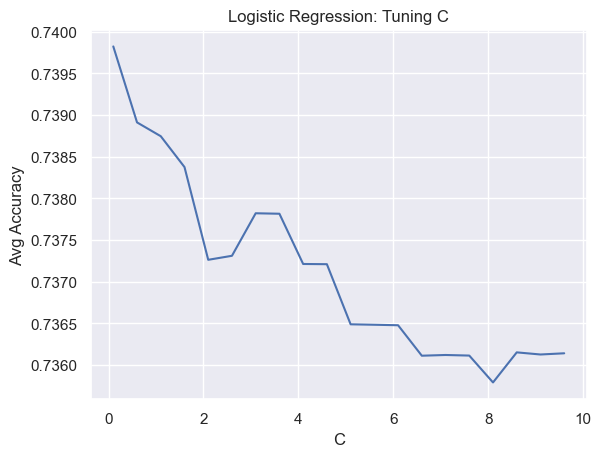

In [ ]:
sns.lineplot(lr_hyperparams, x='C', y='Avg Accuracy')
plt.title('Logistic Regression: Tuning C')

### Score on Query Set

In [ ]:
lr_model = LogisticRegression(max_iter= 200, C=lr_best_param[0], penalty='l2', solver='newton-cholesky')
lr_model.fit(X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1), y_train_use)

preds = lr_model.predict(X_query.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
lr_accuracy = balanced_accuracy_score(y_query, preds)
print(f"Logistic Regression Balanced Accuracy on Query Set: {lr_accuracy}")

Logistic Regression Balanced Accuracy on Query Set: 0.7506222669050479


### Model Analysis

In [ ]:
lr_features = pd.DataFrame({"Features":X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).columns, 
              "Importances":abs(lr_model.coef_[0])}).sort_values(by='Importances', ascending=False)
lr_features

,Features,Importances
6,adp_dist,1.488055
13,post_oracle,1.317316
11,pre_rf_x,0.883381
21,post_nucleus_y,0.777680
10,pre_test_score,0.621819
20,post_nucleus_x,0.476147
19,pre_nucleus_z,0.467766
26,RL_pre,0.449879
34,area3,0.225926
16,post_rf_y,0.225351


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Logistic Regression Feature Importance')

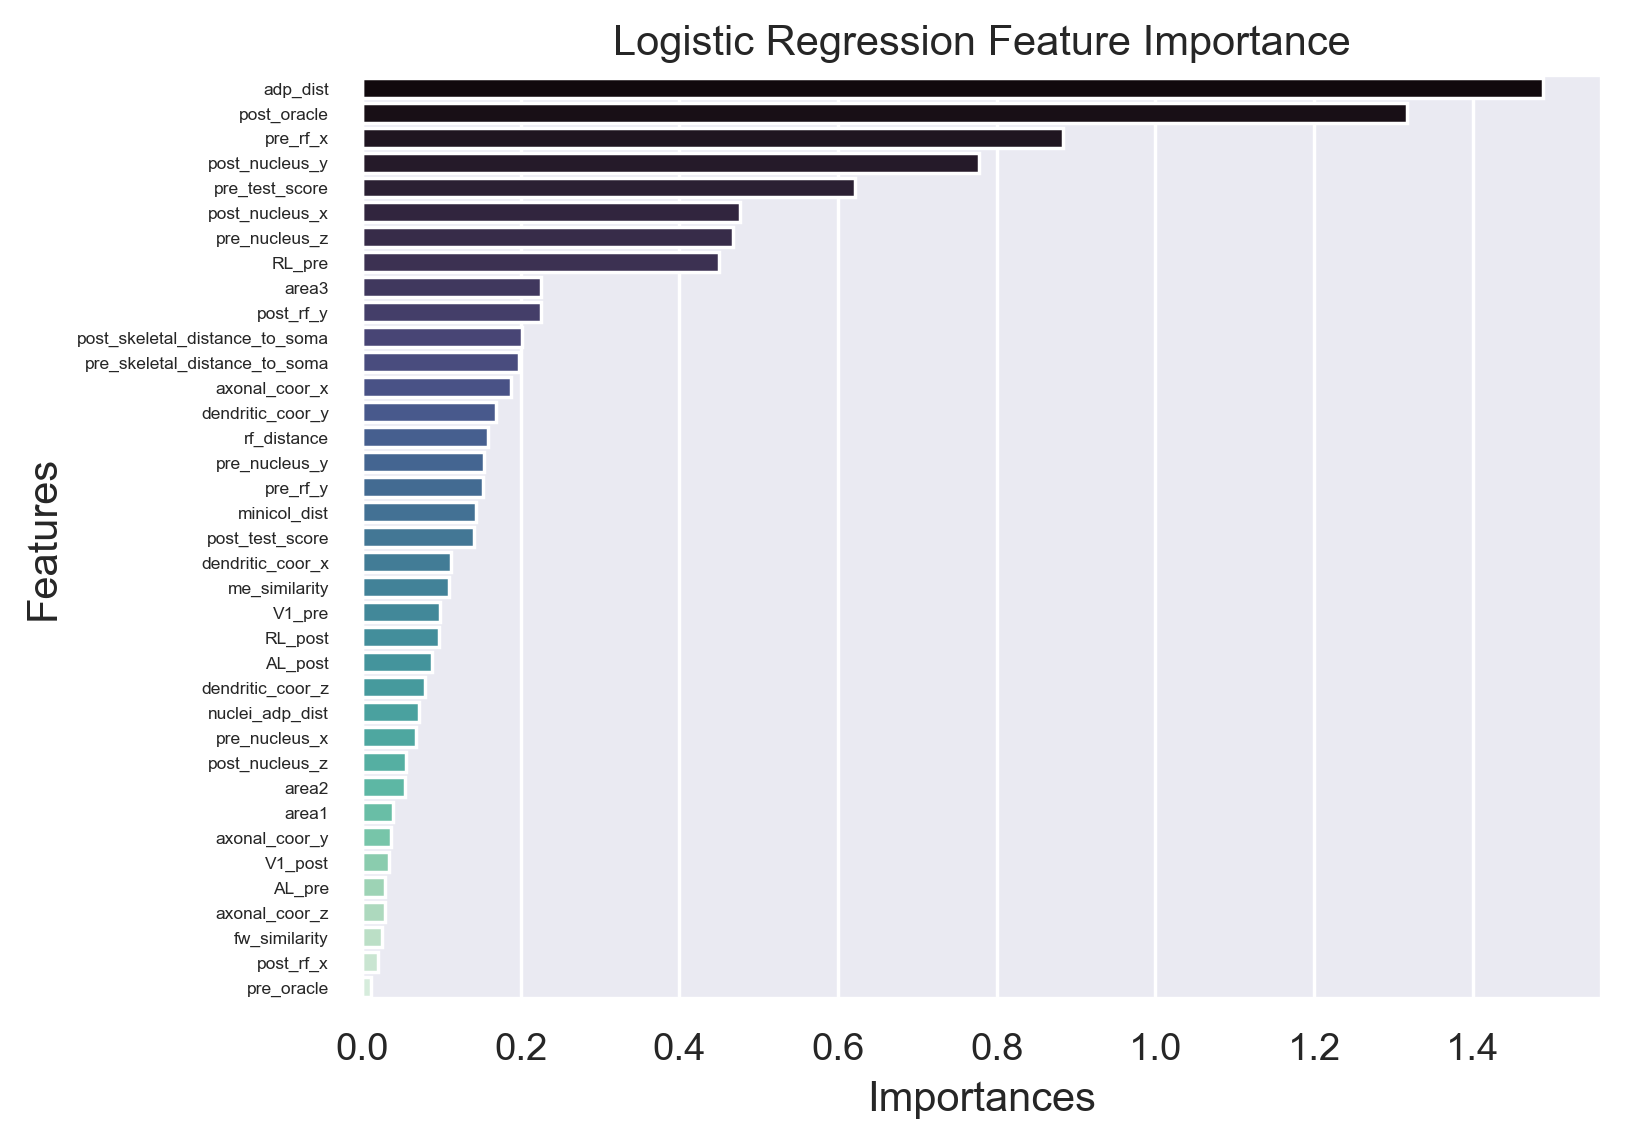

In [ ]:
sns.set_theme(palette='deep')
plt.figure(dpi=250)
g = sns.barplot(lr_features, y='Features', x='Importances', palette='mako')
g.set_yticklabels(g.get_yticklabels(), fontsize=5)
plt.title("Logistic Regression Feature Importance")

### Make a Submission

In [ ]:
leaderboard_path = "Data/leaderboard_data.csv"
sub_data = cleaner(leaderboard_path, feature_path, morph_path)
sub_data = sub_data.select_dtypes('number')
preds = lr_model.predict(sub_data.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
sub_data['connected_pred'] = preds==1
submission_data = sub_data.filter(['ID','connected_pred'])
submission_data.to_csv('final_submission_data_lr.csv',index=False)

# evaluate against real leaderbaord data
solutions = pd.read_csv('Data/solution_data.csv')
leaderboard = pd.concat([solutions,submission_data], axis=1)
public = leaderboard[leaderboard["Usage"]=="Public"]
print("Public Accuracy Score:", balanced_accuracy_score(public["connected"], public["connected_pred"]))
private = leaderboard[leaderboard["Usage"]=="Private"]
print("Private Accuracy Score:", balanced_accuracy_score(private["connected"], private["connected_pred"]))


Public Accuracy Score: 0.7374963301796554
Private Accuracy Score: 0.78139921176348
